In [52]:
# 필요한 모듈 및 패키지 로드

from pyspark.sql.types import * # PySpark 모듈 로드
import pyspark.sql.functions as F

import warnings 
warnings.filterwarnings('ignore') # warning 메시지 반환되지 않도록 설정

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # 한 셀(cell)에서의 코드 실행 결과가 다 보이도록 설정

# Part 1: Analyzing page_views.csv

cf) (Py)Spark에서는 아래와 같이 `StructType`을 사용하여 출력 데이터 프레임의 구조를 생성(column명, 변수의 형(type) 표시)한다.

In [2]:
# page_views 스키마 설정

page_views_schema = StructType(
                    [StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True),
                    StructField("traffic_source", IntegerType(), True)]
                    )

In [3]:
# Google Storage에 저장된 page_views 파일 로드

page_views_df = spark.read.schema(page_views_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("gs://cap-18/data/page_views.csv")

Spark에서는 처리해야 하는 파일 크기를 고려하여 파티션의 수를 설정한다. `page_views` 파일은 파티션의 수가 708개로, 각각이 약 125MB를 처리하도록 설정(88GB / 708개)된 것을 확인할 수 있다. 작업 명령을 내리면, Spark 작업자 노드 가운데 실행 가능한 노드에서 작업이 병렬적으로 진행된다(processed in parallel).

In [6]:
page_views_df.rdd.getNumPartitions()

708

In [7]:
%time page_views_df.show()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
|2aa611f32875c7|        120| 71495491|       1|       CA>ON|             2|
|f55a6eaf2b34ab|        120| 73309199|       1|       BR>27|             2|
|cc01b582c8cbff|        120| 50033577|       1|       CA>BC|             2|
|6c802978b8dd4d|        120| 66590306|       1|       CA>ON|             2|
|f4e423314303ff|        120| 48314254|       1|   US>LA>622|             1|
|3937372ca27

## 1) Page views timestamp stats

먼저 `timestamp` 변수를 요약 통계량 중심으로 살펴보자.

In [8]:
page_views_timestamp_stats_df = page_views_df.describe('timestamp')

In [9]:
page_views_timestamp_stats = page_views_timestamp_stats_df.rdd.collectAsMap()
page_views_timestamp_stats # timestamp의 요약 통계량(count, max, mean, min, stddev) 출력

{u'count': u'2034275448',
 u'max': u'1296000000',
 u'mean': u'6.514646047360121E8',
 u'min': u'0',
 u'stddev': u'3.8097454546369135E8'}

#### Total of page views available in this dataset

In [11]:
page_views_count = int(page_views_timestamp_stats['count'])
print('# Page Views:',page_views_count)

('# Page Views:', 2034275448)


#### Page Views time range

`timestamp`의 분포를 통해 다음의 세 가지 사실을 확인할 수 있다.

- `page_views`에 포함된 데이터는 2016년 6월 14일부터 2016년 6월 28일까지 약 2주 간 수집된 로그 데이터


- timestamp의 최소값/최대값이 대략 새벽 4시로 나타난 것을 보아, UTC-4를 사용하여 데이터셋이 filter되었음을 추정 가능


- 사용자의 선호를 보다 정교하게 모델링하기 위해서는(i.e. `page_views` 데이터가 의미있게 쓰이기 위해서는) 본 데이터가 이 기간 동안 수집된 사용자들의 전체 페이지 방문 기록(full log)이어야 함.

In [12]:
from datetime import datetime
def convert_odd_timestamp(timestamp_ms_relative):
    TIMESTAMP_DELTA=1465876799998
    return datetime.fromtimestamp((int(timestamp_ms_relative)+TIMESTAMP_DELTA)//1000)

In [13]:
print(convert_odd_timestamp(page_views_timestamp_stats['min']))

2016-06-14 03:59:59


In [14]:
print(convert_odd_timestamp(page_views_timestamp_stats['max']))

2016-06-29 03:59:59


## 2) Page views by user

In [15]:
import pandas as pd

In [17]:
# user id별 page_views의 빈도 계산 
page_views_by_user_df = page_views_df.groupBy('uuid').count()

In [18]:
# Grouping page views user counts by counts (to build a histogram)
page_views_user_distribution_df = page_views_by_user_df.select('count').groupby('count').count()

In [21]:
#Converting the PySpark Dataframe to a Pandas Dataframe (for plotting)
page_views_by_user_pandas = page_views_user_distribution_df.toPandas()

In [22]:
len(page_views_by_user_pandas)

563

#### Total number of distinct users in page views

`page_views`에는 717,506,889명의 사용자의 페이지 방문 기록이 포함되어 있다.

In [24]:
distinct_users_count = page_views_by_user_pandas['usersCount'].sum()
distinct_users_count

717506889

유저당 페이지 방문 기록을 살펴보면, 458,234,809명의 유저(전체 유저의 약 63.9%)는 단 한 번만 페이지 방문을 했고, 94,245,789명(전체 유저의 약 13.1%)은 두 차례만 방문한 것을 알 수 있다.

In [23]:
page_views_by_user_pandas.columns = ['pageViewsByUser', 'usersCount']
page_views_by_user_pandas = page_views_by_user_pandas.set_index('pageViewsByUser').sort_index()
page_views_by_user_pandas.head(10)

,usersCount
pageViewsByUser,
1,458234809
2,94245789
3,44977389
4,26869230
5,17942534
6,12878964
7,9691732
8,7573614
9,6036047


In [27]:
%matplotlib inline

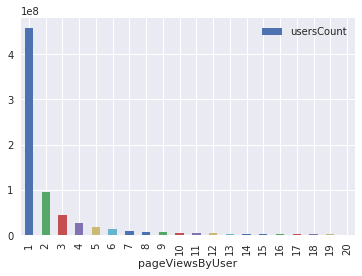

In [30]:
page_views_by_user_pandas.head(20).plot.bar(y = 'usersCount')

N번의 페이지 뷰를 한 유저의 누적 비율을 계산해보면 다음과 같다.

In [34]:
page_views_by_user_pandas['cum_perc'] = (page_views_by_user_pandas['usersCount'].cumsum() / distinct_users_count) * 100
page_views_by_user_pandas.head(10)

,usersCount,cum_perc
pageViewsByUser,,
1,458234809,63.864865
2,94245789,77.000041
3,44977389,83.268606
4,26869230,87.013411
5,17942534,89.514088
6,12878964,91.309049
7,9691732,92.659800
8,7573614,93.715346
9,6036047,94.556598


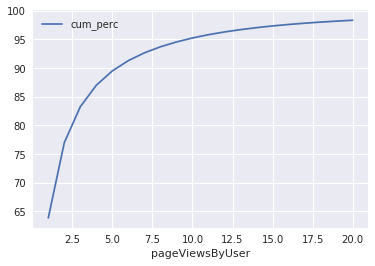

In [35]:
page_views_by_user_pandas.head(20).plot.line(y = 'cum_perc')

페이지 뷰의 수가 많은 일부의 사용자도 있다.

In [36]:
page_views_by_user_pandas.tail(20)

,usersCount,cum_perc
pageViewsByUser,,
625,1,99.999997
632,1,99.999997
638,1,99.999997
640,1,99.999998
649,1,99.999998
651,1,99.999998
652,1,99.999998
655,1,99.999998
659,1,99.999998


`page_views`에서 유저당 페이지 뷰의 평균(2.835)은 `events` 데이터에서의 유저당 페이지 뷰의 평균(1.168)보다 높은 것을 알 수 있다.

In [25]:
avg_page_views_by_user = page_views_count / float(distinct_users_count)
avg_page_views_by_user

2.8351998833561027

## 3) Page views by platform

In [37]:
page_views_by_platform_pandas = page_views_df.groupBy('platform').count().toPandas()

In [38]:
page_views_by_platform_pandas = page_views_by_platform_pandas.set_index('platform').sort_index()
page_views_by_platform_pandas

,count
platform,
1,790149483
2,1053365944
3,190760021


#### Distribution of page views by platform

접속 기기(platform)별 페이지 뷰의 분포를 살펴본 결과, 모바일 - 데스크탑 - 태블릿 순으로 높게 나타났다.

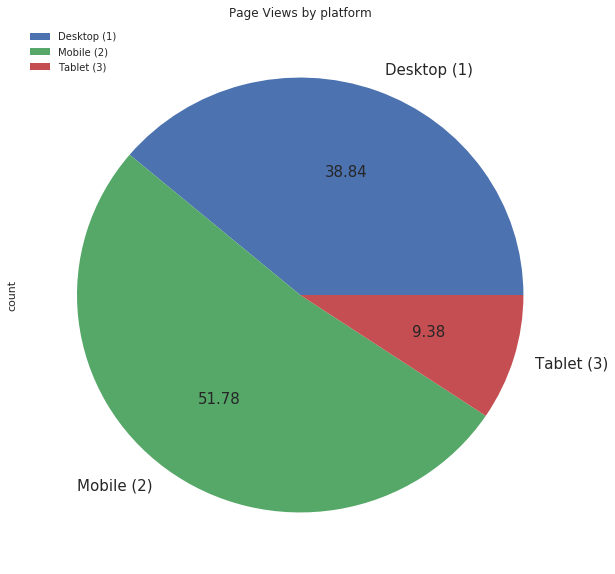

In [45]:
page_views_by_platform_pandas.plot.pie(y='count', figsize=(10, 10), labels=['Desktop (1)', 'Mobile (2)', 'Tablet (3)'], 
              title='Page Views by platform', autopct='%.2f', fontsize=15)

## 4) Page views by Traffic Source

In [48]:
page_views_by_traffic_source_pandas = page_views_df.groupBy('traffic_source').count().toPandas()

In [49]:
page_views_by_traffic_source_pandas = page_views_by_traffic_source_pandas.set_index('traffic_source').sort_index()
page_views_by_traffic_source_pandas

,count
traffic_source,
1,1293550863
2,343133832
3,397590753


#### Distribution of page views by traffic source

접속 경로(traffic source)별 페이지 뷰를 살펴본 결과, 내부(internal) - 검색(search) - 소셜(social) 순으로 높게 나타났다.

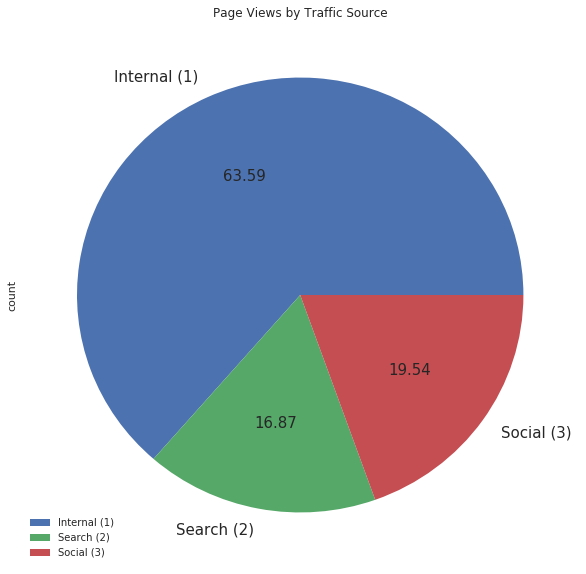

In [50]:
page_views_by_traffic_source_pandas.plot.pie(y='count', figsize=(10, 10), labels=['Internal (1)', 'Search (2)', 'Social (3)'], 
              title='Page Views by Traffic Source', autopct='%.2f', fontsize=15)

## 5) Users visiting a page more than once

특정 페이지에 재방문(i.e. 두 번 이상 접속한 것을 지칭)한 기록은 47,937,415 건으로 높게 나타났다.

In [58]:
page_views_by_user_doc_df = page_views_df.groupBy(['uuid','document_id']).count().alias('count').filter('count > 1')
page_views_by_user_doc_df.count()

47937415

한 사용자가 특정 페이지에 방문한 빈도 순으로 정렬 후 상위 10건을 추출해보자.

In [ ]:
page_views_by_user_doc_df.sort('count', ascending = False).collect().show(10)

이 조합(combination)을 떼내어 각각의 맥락을 살펴보면 다음과 같다.

In [ ]:
def checking_rep_comb(uuid, docu_id):
  page_views_df.filter('uuid = ' + '" + uuid + "' + ' and document_id =' + str(docu_id)).show()
  
def checking_timestamp(ts_list):
  for ts in ts_list:
    print(convert_odd_timestamp(ts))

# Part 2: Exploring relationship with events.csv

In [ ]:
# events 스키마 설정

events_schema = StructType(
                    [StructField("display_id", IntegerType(), True),
                    StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True)]
                    )

# Google Cloud Storage에 저장된 events.csv 파일 로드

events_df = spark.read \
            .schema(events_schema) \
            .options(header='true', inferschema='false', nullValue='\\N') \
            .csv("gs://cap-18/data/events.csv").cache()

In [ ]:
events_df.rdd.getNumPartitions()
events_df.show()

#### Events count

`events.csv`에는 23,120,126 건의 데이터가 포함되어 있다.

In [ ]:
events_count = events_df.count()
events_count

#### Distinct users in events

그 가운데 고유한 유저의 수는 19,794,967명이다.

In [ ]:
distinct_events_users = events_df.agg(F.countDistinct('uuid').alias('count')).collect()[0]['count']
distinct_events_users

#### Average number of events by user

유저당 평균 페이지 뷰의 수는 1.168건이다.

In [ ]:
avg_events_by_user = events_count / float(distinct_events_users)
avg_events_by_user

#### Joining page views - events

`events`가 `page_views`에 포함되는지를 쉽게 확인하기 위해 `dummyPageView`와 `dummyEvent`라는 더미 변수(dummy variable)를 생성해보자. 만약 두 데이터에 공통으로 존재하는 필드(i.e. `uuid`와 `document_id`)를 기준으로 outer_join을 했을 때 `dummyPageView`와 `dummyEvent`가 모두 채워져 있다면 해당 사용자가 해당 페이지에 접속한 기록이 두 테이블에 모두 포함되어 있음을 뜻한다. `dummyPageView`나 `dummyEvent` 중 한쪽만 값을 갖는다면, 어느 한 쪽 테이블이 고유한 유저의 페이지 방문 기록을 갖고 있음을 뜻한다.

In [ ]:
age_views_df = page_views_df.withColumn('dummyPageView', F.lit(1))
events_df = events_df.withColumn('dummyEvent', F.lit(1))

In [ ]:
page_views_events_joined_by_uuid_document_df = page_views_df.alias('page_views').join(events_df.alias('events'), on=['uuid','document_id'], how='outer')

`dummyPageView`나 `dummyEvent` 중 어느 한 쪽만 값을 갖는 케이스는 0 건으로, 이는 `events`가 `page_views`에 포함된다는 것을 의미한다.

In [ ]:
page_views_events_joined_by_uuid_document_df.filter('dummyEvent is not null and dummyPageView is null').count()

`uuid`와 `document_id`를 기준으로 매칭해보면, 

In [ ]:
page_view_events_matches_df = page_views_events_joined_by_uuid_document_df 
                        .filter('dummyPageView is not null and dummyEvent is not null')
%time page_view_events_matches_df.show(200)